# Pretprocesiranje podataka

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ucitavanje podataka 
def load_data_set(file_name):
    ds = []
    data_path = '..'
    data_path = os.path.join(data_path, 'data')
    data_path = os.path.join(data_path, file_name)
    
    df = pd.read_csv(data_path)
    return df
    
        
data = load_data_set('train.csv')

data.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [2]:
data.dtypes

id                   int64
age                  int64
education          float64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [3]:
data.drop(columns = ['id'], inplace=True)

In [4]:
data['TenYearCHD'].unique()

array([1, 0])

Kolona 'TenYearCHD' je ta koja se predvidja, i ona predstavlja rizik da li ce doci do srcanih mana.

## Rad sa nedostajucim vrednostima

In [5]:
data.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

<Axes: >

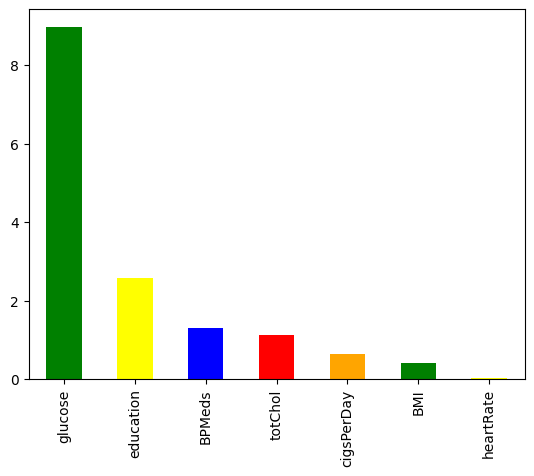

In [6]:
def show_missing():
    missing = data.columns[data.isnull().any()].tolist()
    return missing

round(data[show_missing()].isnull().sum().sort_values(ascending = False)/len(data)*100,2).plot(kind='bar', color=['green', 'yellow', 'blue', 'red','orange'])

In [7]:
print('Train NaN percentage:' +  str (1 - len(data.dropna()) / len(data)))

Train NaN percentage:0.13657817109144543


Kada bi izbacili nedostajuce vrednosti izgubili bi oko 14% podataka. U nastavku cemo pokusati da nadoknadimo nedostajuce vrednosti umesto da ih izbacujemo.

In [8]:
import pandas as pd

tablica_kontigencije = pd.crosstab(data['sex'], data['education'])
udeo_po_polu = tablica_kontigencije.div(tablica_kontigencije.sum(axis=1), axis=0)
print(udeo_po_polu)

education       1.0       2.0       3.0       4.0
sex                                              
F          0.410952  0.314195  0.194577  0.080276
M          0.434599  0.280591  0.128692  0.156118


Vidimo da ne postoji neka prevelika razlika.

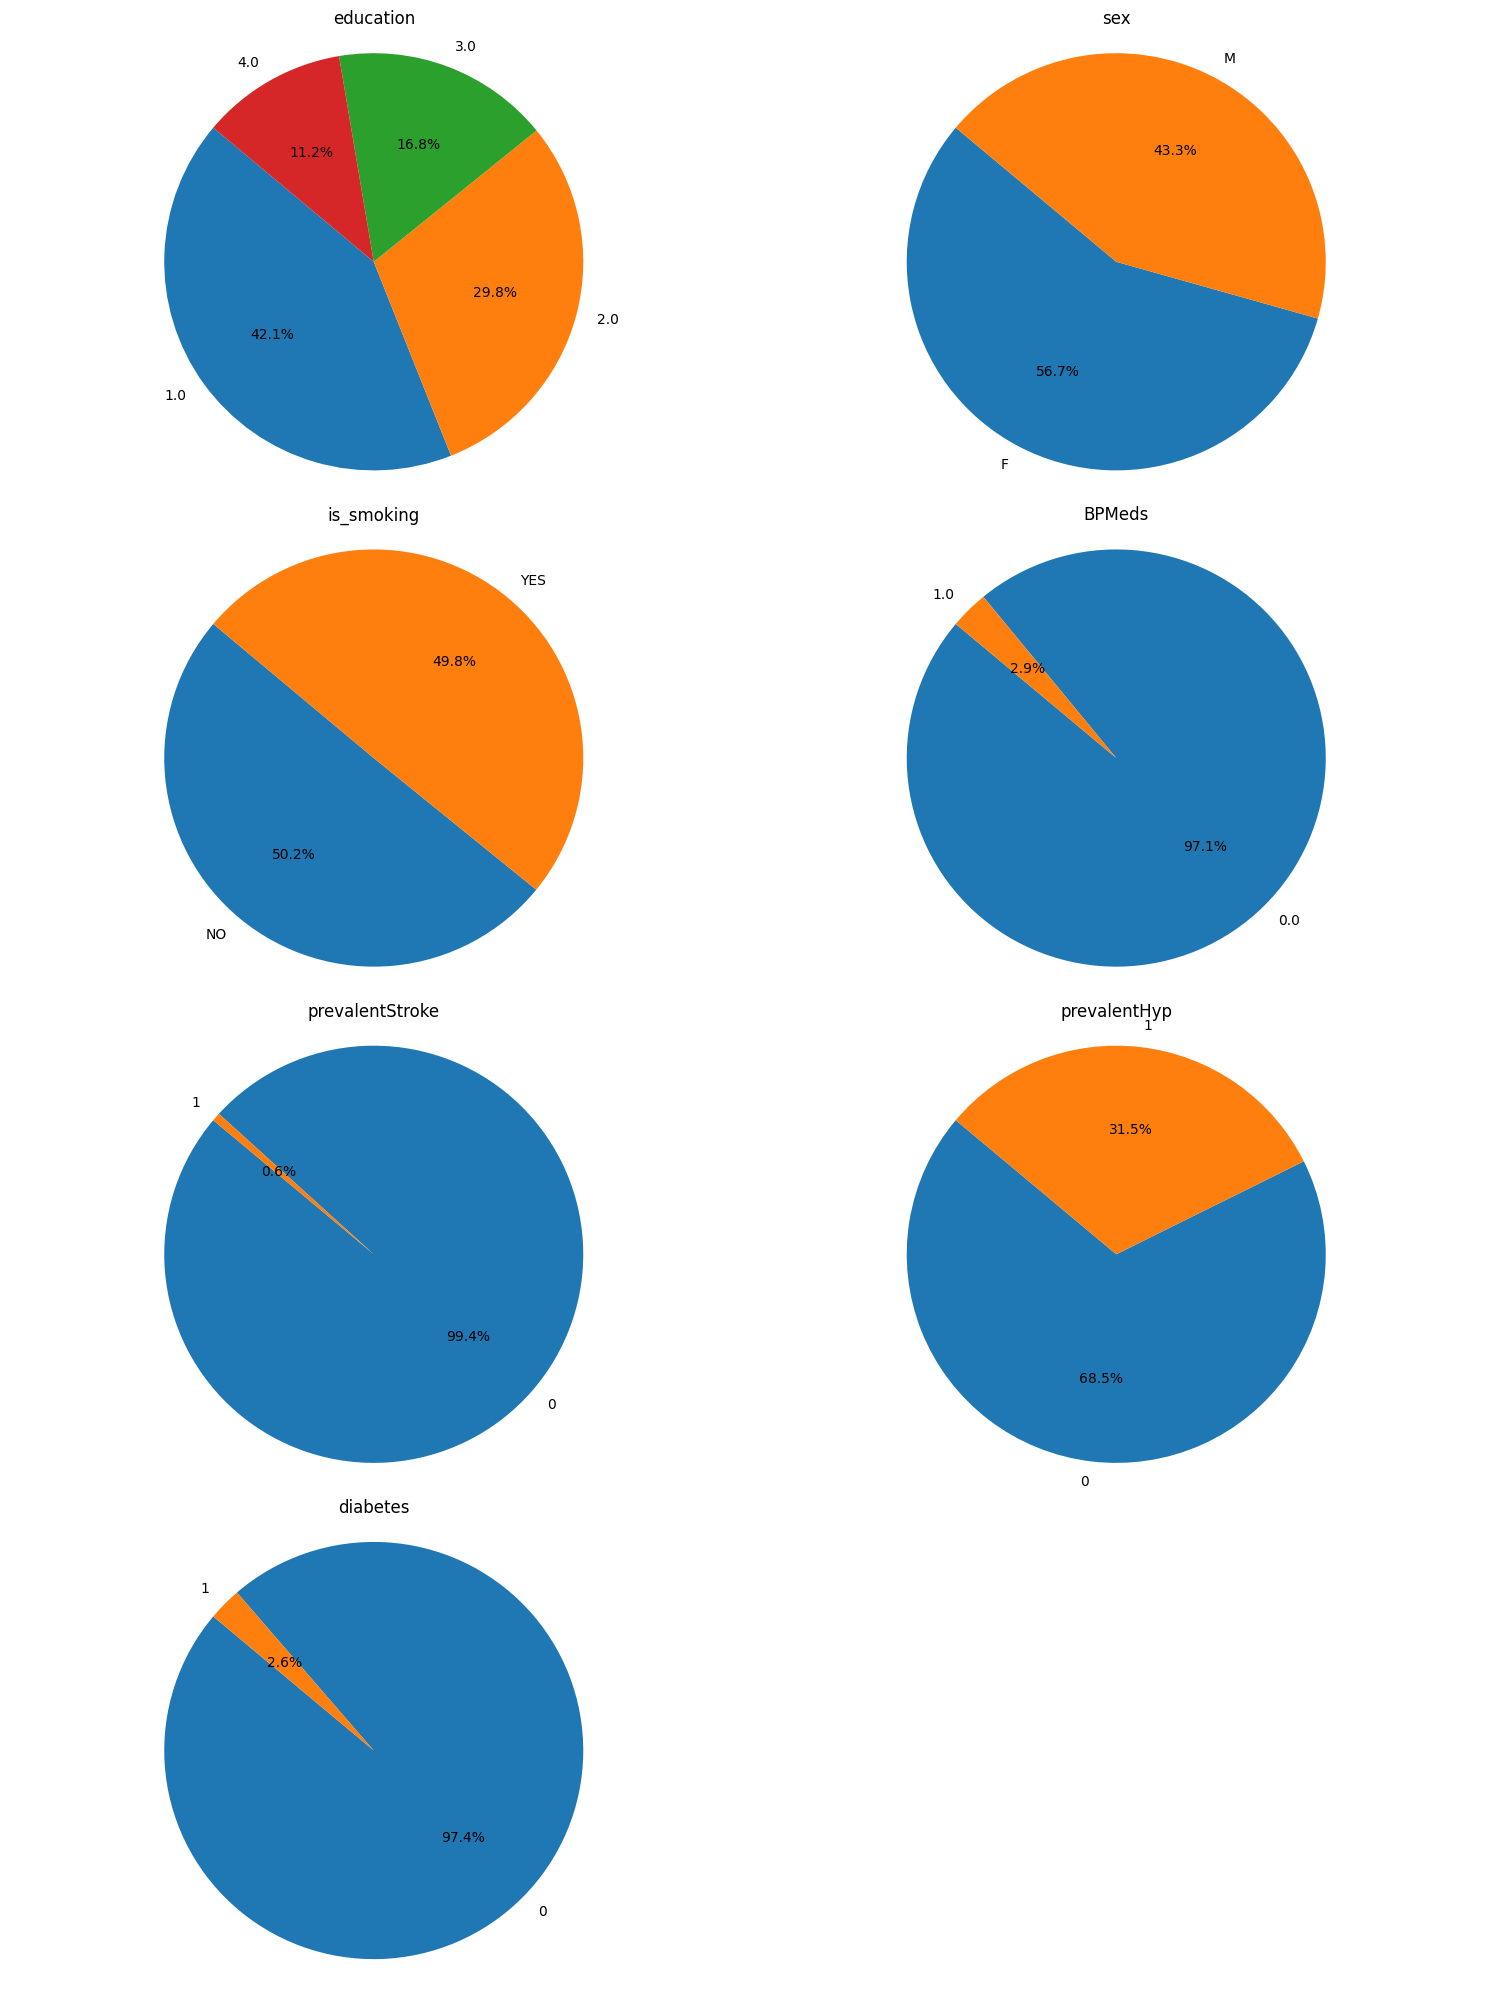

In [9]:
columns_random = ['BPMeds', 'education']

for column in columns_random:
    data[column].ffill(inplace=True)
    
categorical_columns = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

num_columns = 2 
num_rows = (len(categorical_columns) + 1) // num_columns  
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 20))

for i, column_name in enumerate(categorical_columns):
    value_counts = data[column_name].value_counts()
    ax = axes[i // num_columns, i % num_columns]
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')  
    ax.set_title(f'{column_name}')

if len(categorical_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])  

plt.tight_layout()
plt.show()

In [10]:
def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = data[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (data[name] < lower).sum()
        num_of_out_upper = (data[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / data.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(data[name]), max(data[name])    
    return iqr

In [11]:
columns_mean = ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']

IQR(data, columns_mean)

,lower,min,num_lower,upper,max,num_upper,percantage
cigsPerDay,-30.00,0.0,0,50.00,70.0,9,0
totChol,119.00,107.0,2,351.00,696.0,41,1
BMI,15.49,NaN,0,35.57,NaN,77,2
heartRate,45.50,45.0,1,105.50,143.0,63,2
glucose,47.00,40.0,7,111.00,394.0,151,5


In [12]:
from termcolor import colored

print(colored('Mean values: ', 'green'))
print(data[columns_mean].median())

print(colored('Meadian values', 'green'))
print(data[columns_mean].mean())

Mean values: 
cigsPerDay      0.00
totChol       234.00
BMI            25.38
heartRate      75.00
glucose        78.00
dtype: float64
Meadian values
cigsPerDay      9.069477
totChol       237.074284
BMI            25.794964
heartRate      75.977279
glucose        82.086520
dtype: float64


Mozemo primetiti da su median i mean value priblizne za vecinu atributa, u nastavku sam se opredelio da nedostajuce vrednosti za numericke atribute popunim sa njihovim srednjim vrednostima.

In [21]:
import seaborn as sns

def draw_histograms(dataframe, numeric_columns, column_names=None, colors=None):
    if column_names is None:
        column_names = numeric_columns

    sns.set(style='whitegrid')

    num_columns = 2  # Broj kolona
    num_rows = (len(numeric_columns) + 1) // num_columns  # Broj redova

    plt.figure(figsize=(12, 10))

    for i, (col, name) in enumerate(zip(numeric_columns, column_names)):
        plt.subplot(num_rows, num_columns, i + 1)
        sns.histplot(dataframe[col], bins=20, color='skyblue', kde=True)
        plt.xlabel('')
        plt.ylabel('')
        plt.title(f'Histogram za {name}')

    plt.tight_layout()
    plt.show()

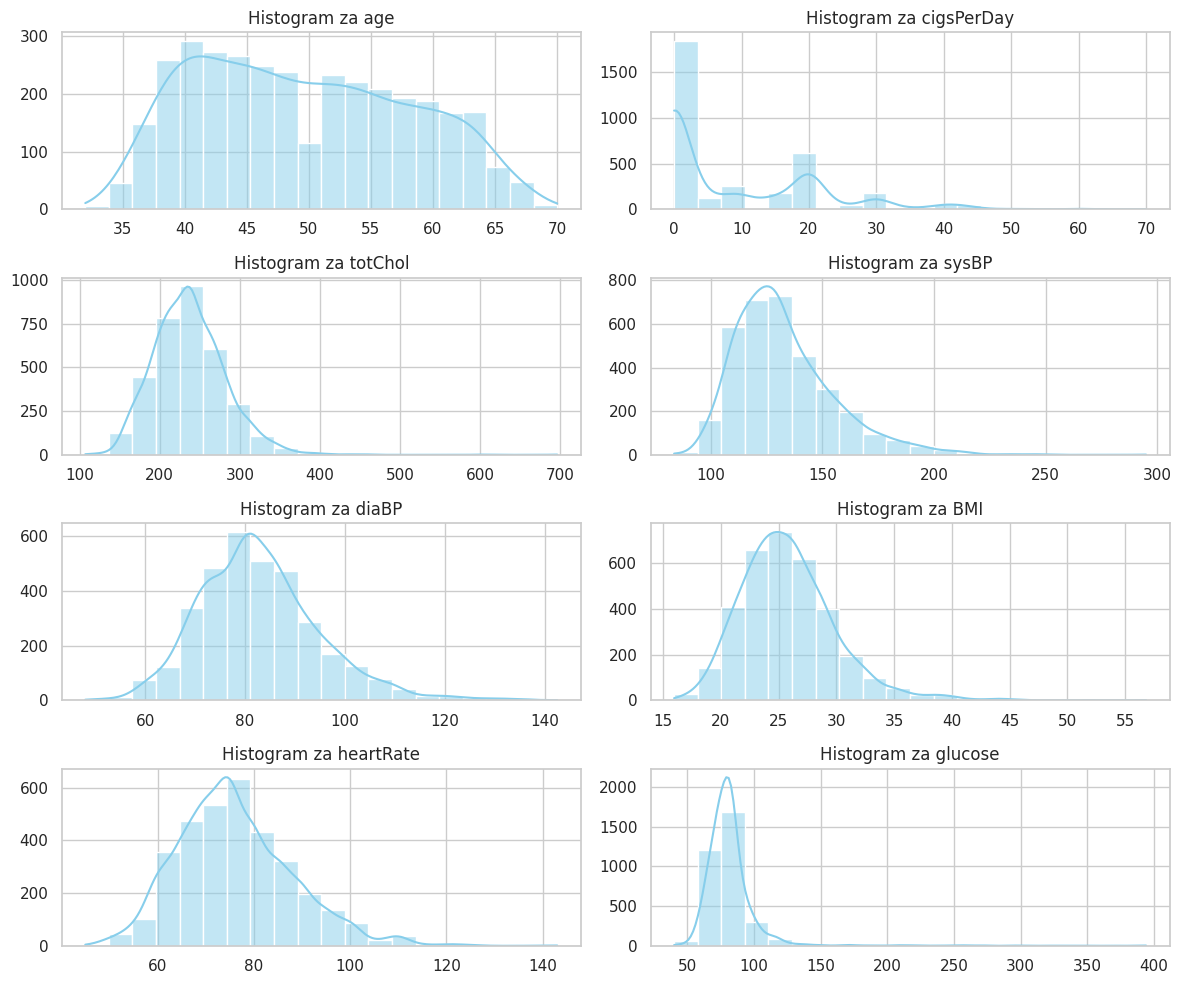

In [22]:
draw_histograms(data, ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], colors=['orange'])

Odavde mozemo videti promene u raspodeli nakon inserovanja nedostajucih vrednosti.

In [23]:
data.fillna(data.mean(), inplace=True)

/tmp/ipykernel_4864/1474580016.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


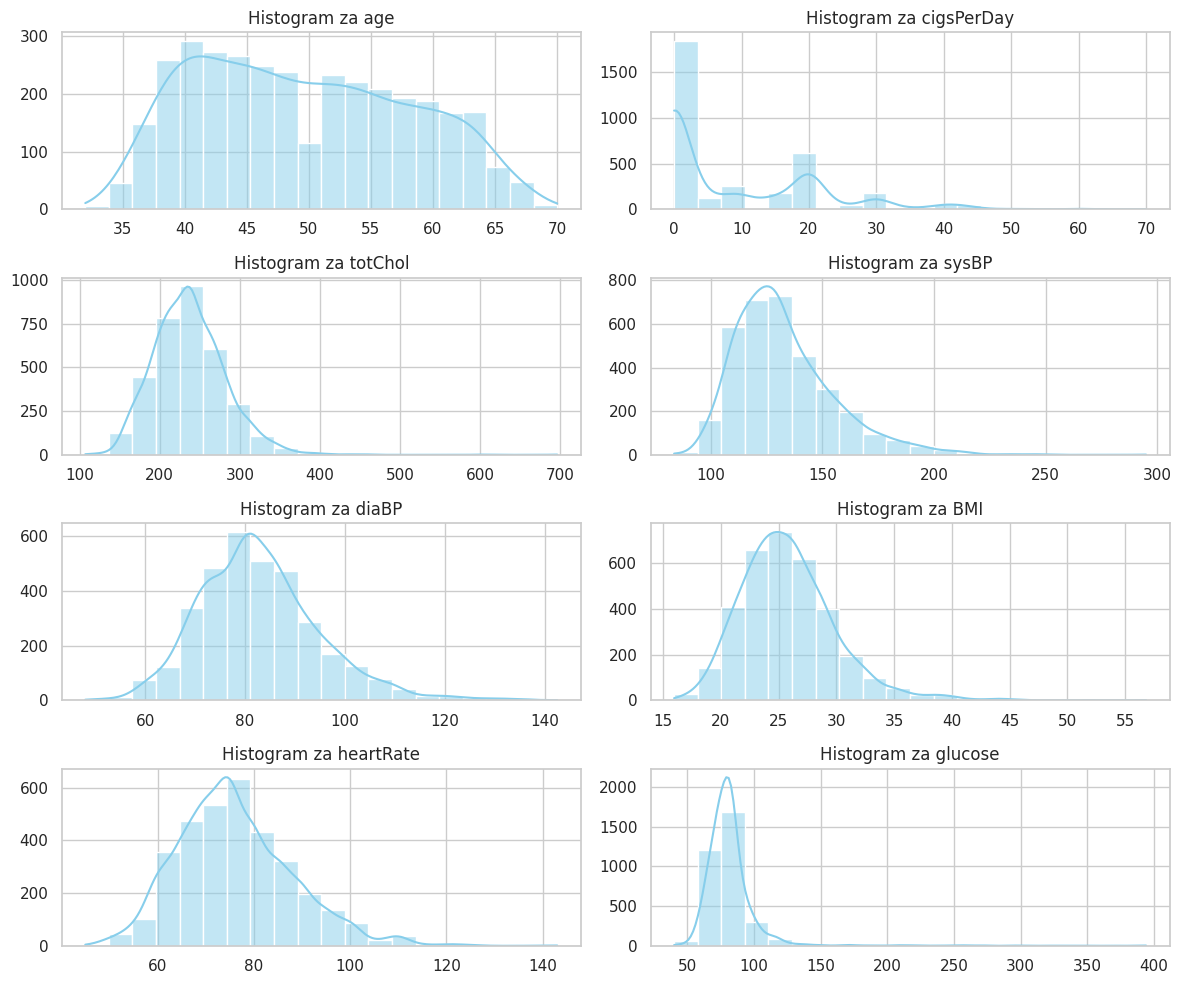

In [24]:
draw_histograms(data, ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], colors='orange')

In [25]:
data['is_smoking'].replace("NO", 0, inplace=True)
data['is_smoking'].replace("YES", 1, inplace=True)
data['sex'].replace('F', 0, inplace=True)
data['sex'].replace('M', 1, inplace=True)
    

data['education'] = data['education'].astype(int)

data = pd.get_dummies(data, columns=['education'], prefix=['degree_level'])

Delimo podatke na test i trening skup.

In [28]:
Y = data['TenYearCHD']
X = data.drop(columns=['TenYearCHD'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=41)

In [29]:
print(X_train.shape)
print(X_test.shape)

(2712, 18)
(678, 18)
